# Notebook 6: Phases of the Ising Model with Logistic Regression


In [38]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


import warnings
#Comment this to turn on warnings
#warnings.filterwarnings('ignore')

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

# Loading in the Ising dataset
We now load in the data which is hosted on Pankaj Mehta's [website](http://physics.bu.edu/~pankajm/MLnotebooks.html).

In [39]:
import pickle, os
from urllib.request import urlopen 

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# Constructing the training and the test sets

In [40]:
from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
30000 critical samples
65000 test samples


## Cost function, optimizers, regularizers, and performance metrics

In Sec. VII of the review, we have shown that the cross-entropy is a natural cost function used for training a logistic regressor. As we already mentioned, minimizing it requires the use of numerical toolboxes. Here, we compare the performance of two different optimization routines: a `liblinear` [the default one for scikit's logistic regression], and stochastic gradient descent (SGD) [see Sec. IV of the review for more details].

It is important to note that all these methods have built-in regularizers. Indeed, we did not discuss the role of the regularisor explicitly in the context of Logistic Regression extensively, yet this concept is crucial in order to prevent overfitting, and we encourage the interested reader to play with the different regularization types and regularization strengths and compare model performances. 

Below, we define the accuracy of a classification model on a given data set as the percentage of correctly classified data points. Comparing the accuracy on the training and test data, we obtain a good estimate of the degree of overfitting. Well-trained models do not overfit the data, which is reflected in an almost equal performance on the training and test data sets [recall that the test set consists of samples which the model has not been trained on]. 

# Run the cell below (this may take several minutes)

accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD: 0.4864, 0.4724, 0.5120
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.4990, 0.4775, 0.5168
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.4862, 0.4486, 0.4779
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.4880, 0.4468, 0.5581
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.6536, 0.6244, 0.6148
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6915, 0.6172
SGD: 0.5467, 0.5094, 0.4009
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6915, 0.6173
SGD: 0.4622, 0.4609, 0.3333
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6912, 0.6186
SGD: 0.4622, 0.4609, 0.3333
finished computing 8/11 iterations
accuracy: train, test, critical
liblin: 0.7249, 0.6874,

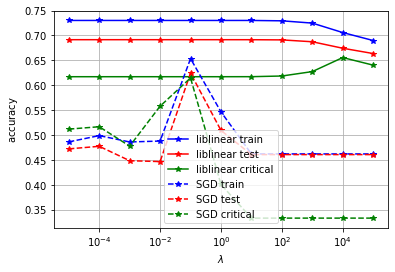

In [41]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=250, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

## Interpreting the results

The first thing we can read off the figure above is the relative degree of overfitting. This information is contained in the difference in accuracy of our model on the training (blue) and test (red) datasets. Notice that the accuracy difference between test and training sets is significant but not unreasonable, within $10\%$. Interestingly, which optimizer performs better depends on the value of the regularization strength. Moreover, similar to the Linear Regression examples, we find that there exists a sweet spot for the regularization strength $\lambda$ that results in optimal performance of the logistic regressor, at about $\lambda\sim 10^{-1}$.

Due to the physics of the Ising model close to criticality, we expect that predicting the phase of a sample will become much more difficult close to the critical point. We can visually see this by looking at the states in the critical region, (see Fig. above and plot other examples). Notice that it is no longer easy even for a trained human eye to distinguish between the ferromagnetic and the disordered phases close to $T_c$. 

It is an interesting exercise to compare the training and test accuracies in the ordered and disordered phases to the accuracy of the model near the critical point (i.e. critical states). Recall that the model is not trained on critical states. Notice that the accuracy is about $10\%$ smaller for the critical states (green curves). 


# Exercises:  

accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.4947, 0.4795, 0.4875
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.5230, 0.4971, 0.5659
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.4183, 0.4078, 0.4485
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.5378, 0.5391, 0.6667
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.5378, 0.5391, 0.6667
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6915, 0.6172
SGD: 0.5378, 0.5391, 0.6667
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6915, 0.6173
SGD: 0.4622, 0.4609, 0.3333
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6912, 0.6186
SGD: 0.4622, 0.4609, 0.3333
finished computing 8/11 ite

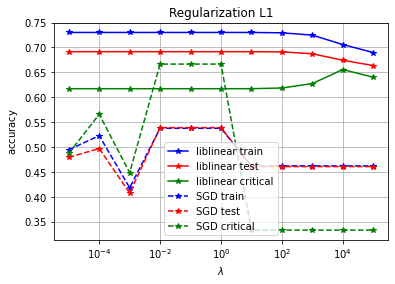

accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.4985, 0.4855, 0.5092
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.5204, 0.4935, 0.5626
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.5139, 0.4849, 0.5776
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.6039, 0.5936, 0.6749
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6916, 0.6172
SGD: 0.5378, 0.5391, 0.6667
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6915, 0.6172
SGD: 0.5378, 0.5391, 0.6667
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7302, 0.6915, 0.6173
SGD: 0.4622, 0.4609, 0.3333
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7294, 0.6912, 0.6186
SGD: 0.4622, 0.4609, 0.3333
finished computing 8/11 ite

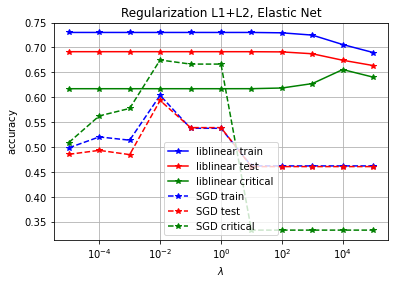

C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuracy: train, test, critical
newton-cg: 0.7302, 0.6916, 0.6172


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD: 0.4985, 0.4804, 0.5103
finished computing 1/11 iterations
accuracy: train, test, critical
newton-cg: 0.7302, 0.6916, 0.6172
SGD: 0.4990, 0.4775, 0.5168
finished computing 2/11 iterations
accuracy: train, test, critical
newton-cg: 0.7302, 0.6916, 0.6172
SGD: 0.4862, 0.4486, 0.4779
finished computing 3/11 iterations
accuracy: train, test, critical
newton-cg: 0.7302, 0.6916, 0.6172
SGD: 0.4880, 0.4468, 0.5581
finished computing 4/11 iterations
accuracy: train, test, critical
newton-cg: 0.7302, 0.6916, 0.6172
SGD: 0.6536, 0.6244, 0.6148
finished computing 5/11 iterations
accuracy: train, test, critical
newton-cg: 0.7302, 0.6915, 0.6172
SGD: 0.5467, 0.5094, 0.4009
finished computing 6/11 iterations
accuracy: train, test, critical
newton-cg: 0.7302, 0.6916, 0.6173
SGD: 0.4622, 0.4609, 0.3333
finished computing 7/11 iterations
accuracy: train, test, critical
newton-cg: 0.7291, 0.6910, 0.6188
SGD: 0.4622, 0.4609, 0.3333
finished computing 8/11 iterations
accuracy: train, test, critical
ne

C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


accuracy: train, test, critical
newton-cg: 0.5379, 0.5392, 0.6667
SGD: 0.4622, 0.4609, 0.3333
finished computing 11/11 iterations


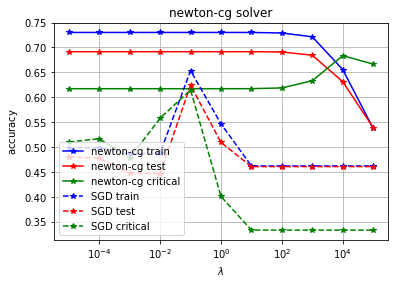

accuracy: train, test, critical
lbfgs: 0.7302, 0.6916, 0.6172


C:\Users\Yi Ming Chang\anaconda3\envs\Tensflow\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


SGD: 0.4985, 0.4804, 0.5103
finished computing 1/11 iterations
accuracy: train, test, critical
lbfgs: 0.7302, 0.6916, 0.6172
SGD: 0.4990, 0.4775, 0.5168
finished computing 2/11 iterations
accuracy: train, test, critical
lbfgs: 0.7302, 0.6916, 0.6172
SGD: 0.4862, 0.4486, 0.4779
finished computing 3/11 iterations
accuracy: train, test, critical
lbfgs: 0.7302, 0.6916, 0.6172
SGD: 0.4880, 0.4468, 0.5581
finished computing 4/11 iterations
accuracy: train, test, critical
lbfgs: 0.7302, 0.6916, 0.6172
SGD: 0.6536, 0.6244, 0.6148
finished computing 5/11 iterations
accuracy: train, test, critical
lbfgs: 0.7302, 0.6916, 0.6172
SGD: 0.5467, 0.5094, 0.4009
finished computing 6/11 iterations
accuracy: train, test, critical
lbfgs: 0.7301, 0.6916, 0.6173
SGD: 0.4622, 0.4609, 0.3333
finished computing 7/11 iterations
accuracy: train, test, critical
lbfgs: 0.7291, 0.6910, 0.6190
SGD: 0.4622, 0.4609, 0.3333
finished computing 8/11 iterations
accuracy: train, test, critical
lbfgs: 0.7215, 0.6845, 0.6333


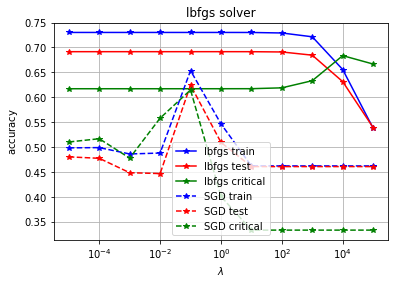

In [42]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l1', alpha=lmbda, max_iter=200, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')
plt.title('Regularization L1')
plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()

plt.show()



# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=lmbda, max_iter=200, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')
plt.title('Regularization L1+L2, Elastic Net')
plt.grid()
plt.legend()

plt.show()



# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='newton-cg') #‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('newton-cg: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=300, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='newton-cg train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='newton-cg test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='newton-cg critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')
plt.title('newton-cg solver')
plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='lbfgs') #‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('lbfgs: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=300, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='lbfgs train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='lbfgs test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='lbfgs critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')
plt.title('lbfgs solver')
plt.grid()
plt.legend()


plt.show()

In [43]:
import numpy as np

import warnings
#Comment this to turn on warnings
#warnings.filterwarnings('ignore')

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

In [44]:
import pickle, os
from urllib.request import urlopen 

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

In [45]:
from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[70000:100000,:]
Y_ordered=labels[70000:100000]

X_critical=data[70000:100000,:]
Y_critical=labels[70000:100000]

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (45000, 1600)
Y_train shape: (45000,)

45000 train samples
30000 critical samples
45000 test samples


accuracy: train, test, critical
liblin: 0.7768, 0.7779, 0.3333
SGD: 0.7604, 0.7554, 0.5894
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7768, 0.7779, 0.3333
SGD: 0.7628, 0.7576, 0.3297
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7768, 0.7779, 0.3333
SGD: 0.7755, 0.7754, 0.3325
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7768, 0.7779, 0.3333
SGD: 0.7770, 0.7783, 0.3333
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7768, 0.7779, 0.3333
SGD: 0.7770, 0.7785, 0.3333
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7768, 0.7779, 0.3333
SGD: 0.7770, 0.7785, 0.3333
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7769, 0.7779, 0.3333
SGD: 0.7770, 0.7785, 0.3333
finished computing 7/11 iterations
accuracy: train, test, critical
liblin: 0.7769, 0.7780, 0.3333
SGD: 0.7770, 0.7785, 0.3333
finished computing 8/11 ite

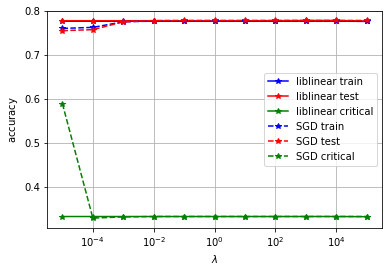

In [46]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )

    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=500, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()


# Answers:

<ul>
<li> Change the regularization to $L^1$, or $L^1+L^2$ (i.e. elastic net, see Notebook 2 for more details), and study the performance of the model.

<li> Try out different solvers supported by `LogisticRegression()`, [see online scikit documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How do they compare to `liblinear` and `SGD`?

<li> One can expect the regressor to be maximally confused exactly at the critical point. Take the data states for the closest temperature, i.e. $T/J=2.5$, and check the performance of the model. Do we get an accuracy of about $50\%$? Does this depend on the proportion of ordered to disordered states in the training set?

For both L1 and L1+L2 (elastic net) regularization, the accuracy of training an testing datasets increases until they reach to $\lambda=10^{-3}$. Then starting decreases as $\lambda$ increases. And training and testing accuracies stablize to 46% afterwards. Unlike train and test dataset, the accuarcy of critical dataset decreases significanltly when $\lambda > 10^0$. Then stablize to 33% of accuracy in high $\lambda$ (regularization strength). Based on the plots, I would suggest that Elastic Net regularization fits the best in low $\lambda$, and L2 regularization fits the best in high $\lambda$. On the other hand, there are no much changes on train, test and critical dataset in log regression, since we use the same solver (liblinear) all the time.

I have plotted $\bf{'newton-cg'}$ and $\bf{'lbfgs'}$ solver in the log regression on the above. The $\bf{'sag'}$ and $\bf{saga}$ took forever, I have only run them for once. In $\bf{sag}$ and $\bf{saga}$ solver, Both SGD (regularization L2) and solvers (sag and saga) coverge twowards 54%. Overall, there is no much difference between $\bf{'newton-cg'}$, $\bf{'lbfgs'}$ and $\bf{'liblinear'}$ solver. Expect in $\bf{'newton-cg'}$ and $\bf{'lbfgs'}$ solver, when regularization strength is high, the accuracy and difference on training and testing dataset decreases.

Yes, it is really confused for the performance of critical point, I don't exactly follow with its pattern. For making $T/J=2.5$, I select the training and testing data point from 70000 to 100000. I was planning to use 90000 to 100000, where the temperature is more likely close to critical temperature, but it won't pass through. Yes, we do get an accuracy above 50% for the training and testing dataset of $\bf{liblinear}$ solver (around 80%).  But no, we don't even have 50% of accuracy for SGD (L2 regularization). It is only around 33% of accuaracy, which is even worst than guessing. Therefore, I think the accuracy of regression is also depending on the proportion of order to disordered states in the training set based on the last figure.

In [ ]:
ADR: 2/2